In [24]:
# general libraries
#import time
import numpy as np
import pandas as pd
#import math
from IPython.display import display

# graphing librarires
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'vscode'

# sklearn libraries
from sklearn.dummy import DummyClassifier
import sklearn.metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# keras libraries
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Input,Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

# boosting models
import xgboost as xgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# treat warnings
import warnings
warnings.filterwarnings('ignore')
        
# view tables
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

## Read Files<a class="anchor" id="1_2"></a>

In [25]:
df = pd.read_csv(r'D:\New folder\WA_Fn-UseC_-Telco-Customer-Churn.csv')

## Display Data<a class="anchor" id="1_3"></a>

In [27]:
# changing all column names to lowercase, for convenience
df.columns = df.columns.str.lower()

In [28]:
display(df.info())
display(df.head())
display(df.describe().T)
print('Nulls',df.isna().sum().sum())
print('Duplicates: ',df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


None

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


,count,mean,std,min,25%,50%,75%,max
seniorcitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthlycharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


Nulls 0
Duplicates:  0


In [9]:
# additional information regarding the customers and the services they get
print('There is a total of {} registered customers.'.format(len(df)))
print('{} of them get internet services . This is {:.2f}% of the total customers.'.format(\
    df[df['internetservice']!='No']['customerid'].count(),df[df['internetservice']!='No']['customerid'].count()*100/len(df)))
print('There are {} customers who have at least one phone line. They are {:.2f}% of the total customers'.format(\
    df[df['phoneservice']=='Yes']['customerid'].count(), df[df['phoneservice']=='Yes']['customerid'].count()*100/len(df)))

There is a total of 7043 registered customers.
5517 of them get internet services . This is 78.33% of the total customers.
There are 6361 customers who have at least one phone line. They are 90.32% of the total customers


## Change columns types<a class="anchor" id="1_4"></a>
Columns that need a type conversion:<br>
- Totalcharges - it's an object and not numeric. We should check why.<br>
- All binary columns - other than the target column - will get the values 0,1 for No/Yes respectively (the columns are: <i>partner, dependents, phoneservice, onlinesecurity, onlinebackup, deviceprotection, techsupport, streamingtv, streamingmovies, paperlessbilling</i>).<br>
- The columns <i>Internetservice</i> and <i>gender</i> are also binary, but the values are not Yes/No. Hence, I will add these columns to the list of columns to encode by OHE method. Those columns include: <i>multiplelines, contract, paymentmethod</i>.<br>

### Totalcharges<a class="anchor" id="1_4_1"></a>

In [29]:
df.loc[df['totalcharges'] == ' ', 'totalcharges'].count()

np.int64(11)

In [30]:
df['totalcharges'] = df['totalcharges'].apply(lambda x: 0 if x==' ' else x)
df['totalcharges'] = df['totalcharges'].astype('float32')
df['totalcharges'].head()

0      29.850000
1    1889.500000
2     108.150002
3    1840.750000
4     151.649994
Name: totalcharges, dtype: float32

### Binary Columns<a class="anchor" id="1_4_2"></a>

In [12]:
# change to 1, 0 values instead pf yes/no, then convert types
for col in ('partner', 'dependents', 'paperlessbilling', 'phoneservice', 'onlinesecurity','onlinebackup', \
            'deviceprotection', 'techsupport', 'streamingtv','streamingmovies'):
    df[col]= df[col].apply(lambda x: 1 if x=='Yes' else 0).astype('int32')
    
df.head(10)

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,1,0,1,0,No phone service,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.850000,No
1,5575-GNVDE,Male,0,0,0,34,1,No,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.500000,No
2,3668-QPYBK,Male,0,0,0,2,1,No,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.150002,Yes
3,7795-CFOCW,Male,0,0,0,45,0,No phone service,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.750000,No
4,9237-HQITU,Female,0,0,0,2,1,No,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.649994,Yes
5,9305-CDSKC,Female,0,0,0,8,1,Yes,Fiber optic,0,0,1,0,1,1,Month-to-month,1,Electronic check,99.65,820.500000,Yes
6,1452-KIOVK,Male,0,0,1,22,1,Yes,Fiber optic,0,1,0,0,1,0,Month-to-month,1,Credit card (automatic),89.10,1949.400024,No
7,6713-OKOMC,Female,0,0,0,10,0,No phone service,DSL,1,0,0,0,0,0,Month-to-month,0,Mailed check,29.75,301.899994,No
8,7892-POOKP,Female,0,1,0,28,1,Yes,Fiber optic,0,0,1,1,1,1,Month-to-month,1,Electronic check,104.80,3046.050049,Yes
9,6388-TABGU,Male,0,0,1,62,1,No,DSL,1,1,0,0,0,0,One year,0,Bank transfer (automatic),56.15,3487.949951,No


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerid        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   seniorcitizen     7043 non-null   int64  
 3   partner           7043 non-null   object 
 4   dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   phoneservice      7043 non-null   object 
 7   multiplelines     7043 non-null   object 
 8   internetservice   7043 non-null   object 
 9   onlinesecurity    7043 non-null   object 
 10  onlinebackup      7043 non-null   object 
 11  deviceprotection  7043 non-null   object 
 12  techsupport       7043 non-null   object 
 13  streamingtv       7043 non-null   object 
 14  streamingmovies   7043 non-null   object 
 15  contract          7043 non-null   object 
 16  paperlessbilling  7043 non-null   object 


## Analysis of the Data<a class="anchor" id="1_5"></a>
We will check out the behavior of both types of customers, those who left and those who stayed, regarding the following:
* What is the their average monthly charges?<br>
* What is the their average total charges?<br>
 - How  are the total charges related to the customers' tenure?<br>
* Do they have internet service?<br>
* Do they have phone service?<br>
 - Do they have multiple lines?<br>
* What kind of a contract do they have?<br>
* How long have they been in the company?<br>

### Monthly charges<a class="anchor" id="1_5_1"></a>

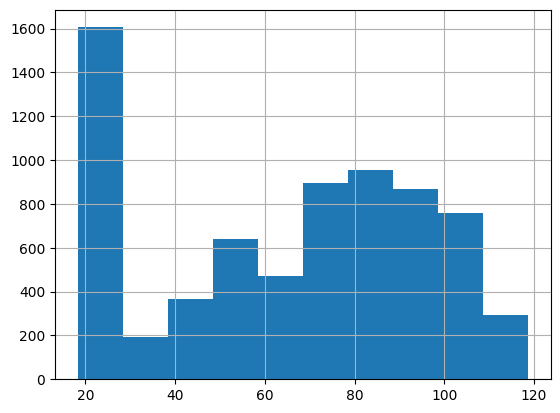

In [32]:
df['monthlycharges'].hist();

In [33]:
# the distribution of the monthly charges is not quite normal, 
# so the main number I will refer to will be the median, rather than the mean
df.pivot_table(index='churn', values='monthlycharges', aggfunc='median')

,monthlycharges
churn,
No,64.425
Yes,79.650


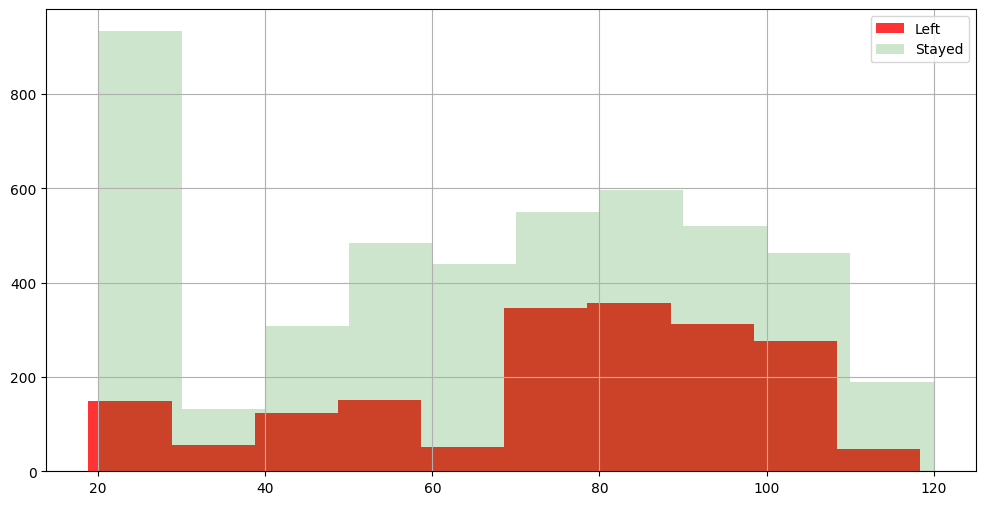

In [34]:
# create two separate datasets for two types of customers: churn and those who stayed
churn = df.loc[df['churn']=='Yes']
stayed = df.loc[df['churn']=='No']

# check the values of monthly charges for both types of customers
churn['monthlycharges'].hist(color='r', alpha=0.8, label='Left', figsize=(12,6))
stayed['monthlycharges'].hist(color='g', alpha=0.2, label='Stayed', range=[20, 120],figsize=(12,6))
plt.legend();

- In the bar plot we can see that the main difference between the two groups, is that in the churn group there are less customers with monthly bills of 20-30. This means that more customers in this group have higher monthly bills, relative to the group of customers who stayed in the company. So indeed, it may be the case of high prices that made them leave the company.

### Total charges and customers' tenure<a class="anchor" id="1_5_2"></a>
- The total charges of the groups of customers who stayed is higher than those of the churn customers. However, the total charges don't tell us much without any indication of the customers lifetime. Therefore, we should check what are the total charges relative to the customers' lifetime.

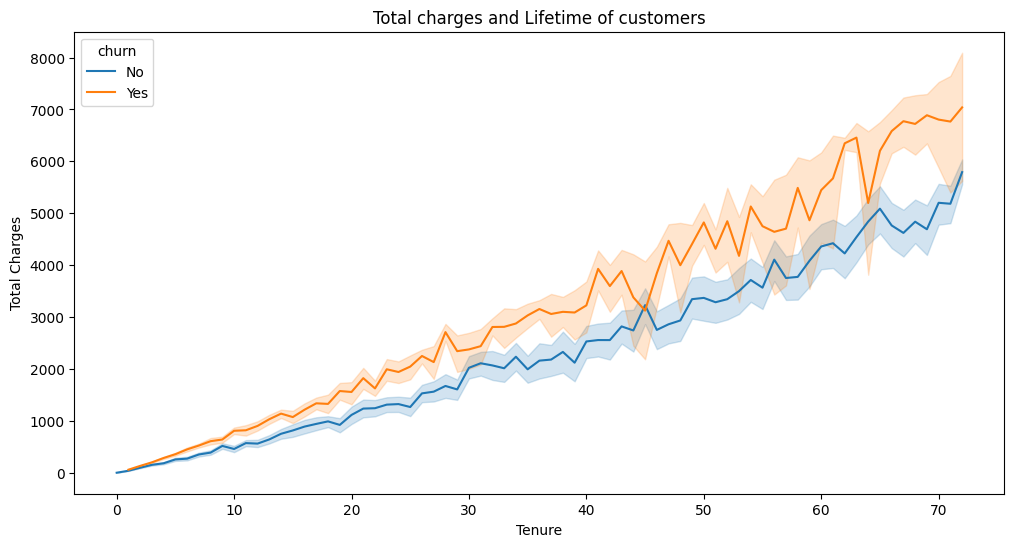

In [35]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.lineplot(x='tenure', y='totalcharges', hue='churn', data=df)
ax.set(title='Total charges and Lifetime of customers')
ax.set_xlabel('Tenure')
ax.set_ylabel('Total Charges');

- In this graph we see more significantly how the total charges of the churn customers increase with time. Despite two "falls" in the total charges, there are more jumps in the numbers of the churn customers. Their line is more linear.<br>
- As opposed to them, the customers who stayed show an increase of total charges with time, but the increase is less linear than with the other group.

### Internet Service<a class="anchor" id="1_5_3"></a>

In [37]:
# customers who left: internet services

fig = go.Figure(data=[go.Pie(labels= churn['internetservice'],  title='Internet Services: customers who left')]) 
fig.show();

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

- 94% of the customers who left had internet.<br>
- 69% used fiber optic internet<br>
- 25% of them had DSL<br>
- Only 6% of them did not have internet services.<br>

In [18]:
# customers who stayed: internet service
fig = go.Figure(data=[go.Pie(labels= stayed['internetservice'],  title='Internet Services: customers who stayed')]) 
fig.show();

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

With the customers who stayed, the division is more equal.<br>
- 73% of these customers had internet<br>
- 35% of these customers had fiber optic, and 38% had DSL<br>
- So more DSL than fiber optic, even though the numbers are close<br>
- We can assume, carefully, given that the median monthly charges of churn customers is higher than that of the other group, that internet is a relatively exepnsive service. Moreover, since the churn customers have much more fiber optic internet service, we can assume that this specific technology is more expensive than DSL.

### Phone Lines<a class="anchor" id="1_5_4"></a>

In [ ]:
# customers who left
fig = go.Figure(data=[go.Pie(labels= churn['multiplelines'],  title='Phone lines: customers who left')]) 
fig.show();

In [ ]:
# customers who stayed
fig = go.Figure(data=[go.Pie(labels= stayed['multiplelines'],  title='Phone lines: customers who stayed')]) 
fig.show();

- 91% of churn customers had a phone service<br>
- 45% of these customers had multiple lines.<br>
- 90% of the customers who stayed have a phone service.<br>
- 49% of these customers had multiple lines.

### Contract Type and Tenure<a class="anchor" id="1_5_5"></a>

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax = sns.stripplot(x='contract', y='tenure', hue='churn', data=df)
ax.set(title='Contract Type and Tenure of customers')
ax.set_xlabel('Contract Type')
ax.set_ylabel('Tenure');

- In general, we see more churn customers in the month to month column: more than in other columns, and more than the customers who stayed in the company<br>
- As to the Tenure, in the one and two year contract columns, there more customers who stayed with longer tenures: relative to churn customer, relative to the month to month column, and relative to the number of customers in these columns who have a shorter lifetime<br>
- This means again that churn customers were more month to month customers, and with shorter lifetimes in the company<br>
- Churn customers who happen to be in a one or two year contract have a longer lifetime than those in month to month.

### How long have they been in the company?<a class="anchor" id="1_5_6"></a>

In [ ]:
churn['tenure'].hist(color='r', alpha=0.8, label='Left', figsize=(12,6))
stayed['tenure'].hist(color='g', alpha=0.4, label='Stayed',figsize=(12,6))
plt.legend();

- Here it is easy to see that the average tenure of churned customers' is much shorter than the tenure of customers who stayed.<br>
- The range of months is 0-75, and most of the churned customers were in the range of 0-25.<br>
- This may add the factor of loyalty to the company (actively or passively), which differentiates the two groups. As we saw in the plot of the contract type.

### EDA conclusions:<a class="anchor" id="1_5_7"></a>
- The median monthly charge is 79.65 for churned customers and 64.42 for those who stayed.<Br>
- Internet service: most of the churned customers had internet service. Only 6% of them did not have this service. 70% of all churned customers had fiber optic.<br>
- The majority of churned customers had a month to month contract.<br>
- The majority of churned customers were at the company for less than a year.

# ML Models<a class="anchor" id="2"></a>
- Note that the data is <b>imbalanced (the target column has 73% of customers who stayed, vs. 27% who left)</b>.<br>
- I will deal with the imbalance soon, in order to be able to use the ROC AUC score for the models.<br>
- I could have taken a deeper care of the outliers, especially in the tenure column. However, I would like to suggest another approach: use data of the last 5 years only. We see that the end dates are only in the last 4 months (relative to February 2020). We don't have data about customers who left before. In addition to that, most of the churn customers enrolled recently (in the last 10 months). Their behavior has nothing to do with what happened a long time ago.<br>
- I will suggest to limit the data to years 2015 on.

## Preprocessing<a class="anchor" id="2_1"></a>
### Dropping 'customerid' feature<a class="anchor" id="2_1_1"></a>

In [ ]:
df = df.drop('customerid', axis=1)

### Features Histogram<a class="anchor" id="2_1_2"></a>

In [ ]:
df.hist(edgecolor='black', linewidth=1.2, figsize=(18,12));

### Separating the target column<a class="anchor" id="2_1_3"></a>

In [ ]:
df['churn'] = df['churn'].apply(lambda x: 0 if x=='No' else 1)
target = df['churn']
(target.value_counts(normalize=True)*100).round(2)

### Encoding categorical features using OHE<a class="anchor" id="2_1_4"></a>

In [ ]:
# OHE on the categorical columns
def OHE_encoding(df):
    ohe_cols = ['internetservice','gender','paymentmethod', 'multiplelines', 'contract']
    
    # OHE encoding
    data_ohe = pd.get_dummies(df[ohe_cols], drop_first=True)
    
    # join the columns and drop the relevant columns
    features = df.join(data_ohe).drop(['internetservice','gender','paymentmethod', 'multiplelines', 'contract'], axis=1)
    
    return features

In [ ]:
encoded = OHE_encoding(df)

encoded.head()

### Display correlation between features and the target<a class="anchor" id="2_1_5"></a>

In [ ]:
ax = plt.axes()
plt.gcf().set_size_inches(3,10)
sns.heatmap(encoded.corr()[['churn']].sort_values('churn', ascending=False), cmap='Blues', annot=True)
ax.set_title('Features Correlations')

plt.show();

- The only features that have some correlation to the target are internetservice of fiber optic, which makes sense because it's an expensive product.<br>
- And payment method of electronic check, which seems random, unless it is a complicated paying method that annoys customers.<br>
- All the other features are not worth mentioning, wrt to their correlation with the target.

### Splitting the Data<a class="anchor" id="2_1_6"></a>

In [ ]:
features = encoded.drop(['churn'],axis=1)

In [ ]:
features_train, features_test, target_train, target_test = \
train_test_split(features, target, test_size=0.15, random_state=12345)

### Dealing with imbalanced data<a class="anchor" id="2_1_7"></a>
#### Upsampling<a class="anchor" id="2_1_7_1"></a>

In [ ]:
def upsample(features, target, repeat):
    
    '''
    - Takes features_train, target_train and a number for multiplication (repeat).
    Resamples both sets, features_train and target_train, to include the both:
    1. the same number of zeros as in the original sets
    2. the repetition number (repeat) multiplied by the ones in the original sets.
    - Prints the new shapes of the sets
    - Returns the new sets: features_upsampled, target_unsampled.
    '''
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    
    print('features_upsampled:',features_upsampled.shape)
    print('target_upsampled:',target_upsampled.shape)
    print()

    return features_upsampled, target_upsampled

#### Downsampling<a class="anchor" id="2_1_7_2"></a>

In [ ]:
def downsample(features, target, fraction):
    
    '''
    - Takes features_train, target_train and a fraction (float under 1) for multiplication (fraction).
    Resamples both sets, features_train and target_train, to include both:
    1. a random sample of zeros in the size of the original zeros in the set multiplied by the given fraction
    2. the same number of ones as in the original sets.
    - Prints the new shapes of the sets
    - Returns the new sets: features_downsampled, target_downsampled.
    '''
        
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)]
        + [features_ones])
    
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    print('features_downsampled:',features_downsampled.shape)
    print('target_downsampled:',target_downsampled.shape)
    print()

    return features_downsampled, target_downsampled

#### Adding class_weight / scale_pos_weight parameter to models with this parameter<a class="anchor" id="2_1_7_3"></a>
- Parameter <i>class_weight</i> exists in most the sklearn models.<br>
- Parameter <i>scale_pos_weight</i> exists in other bossting models.

## Training the models<a class="anchor" id="2_2"></a>
In all the models, other than the neural networks one, I will use GridSearchCV for tuning the hyperparameters. I will use a pipeline, and scale the data from the pipeline to avoid data leakage.<br>
### Train the Model<a class="anchor" id="2_2_1"></a>

In [ ]:
# a function that gets parameters and train the model via gridsearch to find the best parameters and best score
def train_model(model, params, X, Y, X_test, Y_test, models, names, model_name):
    
    '''
    Takes: 
    - a specific model
    - a specific dictionary of hyper-parameters for this model
    - features_train
    - target_train
    - features_test
    - target test
    - a set of models
    - a set of names
    - the specific model's name
    Creates: 
    - a pipeline to run the model through
    - a cross-validation model that runs the pipeline
    Sends parameters to the following functions:
    - a function that saves the desired scores for the model (model_scores)
    - a function that displays the most important features for this model (feature_importance)
    Prints:
    - best parameters for the models
    - best roc auc score for the train set
   '''
    
    # defining the pipeline
    pipeline = Pipeline([('scale', StandardScaler()), ('model', model) ])
    
    # use gridsearchCV for cross validation
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, scoring=['roc_auc','accuracy', 'f1'], refit='roc_auc')
    grid.fit(X,Y)
    
    # display best score on train
    print('Best roc auc score (on train set):',grid.best_score_)
    
    # display scores
    model_scores(grid, X_test,  models, Y_test, names, model_name)
    
    # display features importances
    feature_importances(X, grid)
       
    # display best parameters
    print('Best parameters:\n',grid.best_params_)
    print()

### Display Scores<a class="anchor" id="2_2_2"></a>

In [ ]:
# create sets to store information added about the models
models = {'roc auc': [], 'accuracy': [], 'f1': [], 'TP': [], 'TN':[], 'FP':[], 'FN':[]}
names = []

In [ ]:
def model_scores(model, X_test, models, Y_test, names, model_name):
    
    '''
    Takes:
    - a specific model
    - features_test
    - a set of models
    - target_test
    - a set of names of models
    - the name of specific model
    Creates:
    - predictions usig predict_proba, for the roc auc score
    - predicition using predict method for the other scores
    Appends:
    - the set of models with three scores for the model
    - the set of models names with the current model's name
    Sends:
    - parameters to the function that displays the confusion matrix of the model and it's roc curve (cm_roc_auc_curve)
    - if the model does not have a cunfusion matrix of a roc curve, the function skips this action    
    '''
    
    # for the roc auc score we need to use predict proba
    predictions = model.predict_proba(X_test)[:,1]
    # for accuracy and f1 we will use predict, as usual
    preds = model.predict(X_test)
    
    # collects scores to the dataset
    models['roc auc'].append(roc_auc_score(Y_test, predictions))
    models['accuracy'].append(accuracy_score(Y_test, preds))
    models['f1'].append(f1_score(Y_test, preds))
    
    # add the model's name to the above table
    names.append(model_name)
    
    # send to the function that displays confusion matrix and the roc curve
    try:
        cm_roc_auc_curve(model, X_test, Y_test, preds, models, names)
    except:
        print()

### Confusion Matrix and ROC Curve<a class="anchor" id="2_2_3"></a>

In [ ]:
# print confusion matix + roc auc curve
def cm_roc_auc_curve(model, X_test, y_test, predictions, models, names):
    
    '''
    Takes:
    - the specific model run by the GrdSearchCV
    - features_test
    - target_test
    - the roc auc predictions
    - the set of models, updated
    - the set of models' names, updated
    Adds to the models set:
    - the values of the confusion matrix (TP, TN, FP, FN)
    Displays:
    - the models set in its current stage (including all the model so far) with their scores and confusion matrix values
    - a heatmap of the confusion matrix
    - the roc curve of the current model
    
    '''
    probabilities_one_valid = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_valid)
    cm = confusion_matrix(y_test, predictions, labels=[1,0])
    
    # add information about tp,tn,fp,fn
    models['TP'].append(cm[0,0])
    models['TN'].append(cm[1,1])
    models['FP'].append(cm[0,1])
    models['FN'].append(cm[1,0])
    
    # sort the table
    models = pd.DataFrame(models, index=names).sort_values('roc auc', ascending=False)
    
    # display the scores of the all the models we have so far
    display(models)
    
    # plot confusion matrix
    plot_confusion_matrix(model,X_test,y_test)
    
    # roc auc curve
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for the model')
    plt.show()

### Feature Importance<a class="anchor" id="2_2_4"></a>

In [ ]:
def feature_importances(X, model):
    
    '''
    Takes:
    - features_train
    - a specific model that was run through GridSearchCV
    Tries:
    - to display the 3 most important features of the model
    - If it's unable to do so, it prints a message telling that the model does not have the method of features importance
    '''
    
    try:
        feature_importance = pd.DataFrame({'features':X.columns,'importance':model.best_estimator_._final_estimator.feature_importances_})
        print(feature_importance.sort_values('importance',ascending=False).head(3))
        print()
        
    except:
        try:
            feature_importance=pd.DataFrame({'feature':list(X.columns),'importance':[abs(i) for i in model.best_estimator_._final_estimator.coef_[0]]})
            print(feature_importance.sort_values('importance',ascending=False).head(3))
            print()

        except:
            print('This model does not have a feature importance attribute')      

## Baseline models<a class="anchor" id="2_3"></a>
### Dummy Model<a class="anchor" id="2_3_1"></a>

In [ ]:
# define hyper parameters for the model
clf_param = {'model__strategy': ['most_frequent', 'stratified', 'uniform']}

# run the model 
print('Running Dummy Classifier without balancing the data')
train_model(DummyClassifier(),clf_param,features_train, target_train, features_test, target_test, models, \
             names ,'Dummy Model: imbalanced')

### LogisticRegression<a class="anchor" id="2_3_2"></a>

In [ ]:
# define hyper parameters for the model
lr_param = {'model__penalty': ['l2', 'elasticnet'], 'model__solver':['saga'],'model__l1_ratio':[0.05,0.1,0.2]}

# run the model
print('Running Logistic Regression without balancing the data')
train_model(LogisticRegression(random_state=12345,), lr_param, features_train, target_train, features_test, target_test,\
        models, names ,'Logistic Regression: imbalanced')

print('Running LR with balancing with class weight parameter')
# X = features_train[['monthlycharges','lifetime','totalcharges','internetservice_No','internetservice_Fiber optic','type_Two year']]
train_model(LogisticRegression(random_state=12345, class_weight = 'balanced'), lr_param, features_train, target_train,\
         features_test, target_test, models, names ,'Logistic Regression: balanced')

## Tree models<a class="anchor" id="2_4"></a>
### Decision Tree<a class="anchor" id="2_4_1"></a>

In [ ]:
# define hyper parameters for the model
dt_param = {'model__max_depth' : [4,6,8],'model__min_samples_split' : [100,120,150],\
                'model__min_samples_leaf': [6,8,10], 'model__criterion': ['gini', 'entropy']}

# run the model
print('Running Decision Tree without balancing the data')
train_model(DecisionTreeClassifier(random_state=12345), dt_param, features_train, target_train, features_test,\
         target_test, models,names ,'Decision Tree: imbalanced')

print('Running DT with balancing with class weight parameter')
train_model(DecisionTreeClassifier(random_state=12345, class_weight='balanced'), dt_param, features_train , target_train, \
         features_test, target_test, models, names,'Decision Tree: balanced')

### Random Forest<a class="anchor" id="2_4_2"></a>

In [ ]:
# define hyper parameters for the model
rf_param = {'model__max_depth' : [4,5,6], 'model__n_estimators' : [120,135,175], 'model__min_samples_split':[2,4,6]}

# run the model
print('Running Random Forest without balancing the data')
train_model(RandomForestClassifier(random_state=12345, criterion='entropy'), rf_param, features_train, target_train, features_test, target_test,\
         models, names ,'Random Forest: imbalanced')

print('Running RF with balancing with class weight parameter')
train_model(RandomForestClassifier(random_state=12345, criterion='entropy', class_weight = 'balanced'), rf_param, features_train, target_train,\
             features_test, target_test, models, names ,'Random Forest: balanced')

## Boosting models<a class="anchor" id="2_5"></a>
### Gradient Boosting<a class="anchor" id="2_5_1"></a>

In [ ]:
# define hyper parameters for the model
gb_param = {'model__max_depth' : [2,4,6], 'model__n_estimators': [80,150,230] }

# run the model
print('Running Gradient Boosting without balancing the data (note that this model has no parameter that deals with imbalance)')
train_model(GradientBoostingClassifier(random_state=42), gb_param, features_train, target_train, features_test, \
             target_test,models, names ,'Gradient Boosting: imbalanced')

### XGBoost<a class="anchor" id="2_5_2"></a>

In [ ]:
# define hyper parameters for the model
xgb_param = {'model__max_depth' : [2,4,6],'model__learning_rate': [0.01,0.05,0.1],\
                 'model__n_estimators': [150,250,280], 'model__booster':['gbtree', 'gblinear','dart']}

#spq = calculating the value of total negative observations divided by total positive observations
spw = (lambda x: x[0]/x[1])(target.value_counts())

# run the model
print('Running XGBoost without balancing the data')
train_model(XGBClassifier(random_state=12345, verbosity = 0), xgb_param, features_train, target_train, features_test,\
             target_test, models, names ,'XGBoost: imbalanced')

print('Running XGBoost with scale_pos_weight parameter')
train_model(XGBClassifier(random_state=12345, verbosity = 0, scale_pos_weight= spw), xgb_param, \
          features_train, target_train, features_test, target_test, models, names ,'XGBoost: balanced')

### CatBoost<a class="anchor" id="2_5_3"></a>

In [ ]:
# define hyper parameters for the model
cb_param = {'model__depth' : [1,2,3], 'model__iterations': [310,320,330], 'model__learning_rate':[0.05,0.08,0.1]\
                , 'model__reg_lambda':[0.05, 0.08, 0.1]} 

# run the model
print('Running CatBoost without balancing the data')
train_model(CatBoostClassifier(random_seed = 42, verbose=0, eval_metric='AUC'), cb_param, features_train, target_train, \
             features_test, target_test, models, names ,'CatBoostB: imbalanced')

print('Running CatBoost with balancing with class weight parameter')
train_model(CatBoostClassifier(random_seed = 42, verbose=0, scale_pos_weight= spw), cb_param, features_train, \
         target_train, features_test, target_test, models, names ,'CatBoost: balanced')

## Neural Networks<a class="anchor" id="2_6"></a>

In [ ]:
# scaling the features
scaler = MinMaxScaler()
X = scaler.fit_transform(features_train)
X_test = scaler.transform(features_test)

In [ ]:
# building the neural network
model = Sequential()
model.add(Dense(16, input_dim=(X.shape[1]), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compiling the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['AUC'])

# fit model
model.fit(features_train, target_train, validation_data=(X_test, target_test), epochs=100, batch_size = 10, verbose=None)
model.summary()

predictions = model.predict(X_test)

In [ ]:
# add scores to the models datarame
models['roc auc'].append(roc_auc_score(target_test, predictions))
models['accuracy'].append('--')
models['f1'].append('--')
models['TP'].append('--')
models['TN'].append('--')
models['FP'].append('--')
models['FN'].append('--')


names.append('Neural Networks: imbalanced')
models = pd.DataFrame(models, index=names).sort_values('roc auc', ascending=False)
display(models)

## Try the best model (CatBoost) with Upsampling and Downsampling<a class="anchor" id="2_7"></a>
### Upsampling<a class="anchor" id="2_7_1"></a>

In [ ]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 10)

model = CatBoostClassifier(random_seed = 42, verbose=0, eval_metric='AUC', depth= 1, iterations= 330, learning_rate= 0.08, reg_lambda= 0.1)
fit = model.fit(features_upsampled, target_upsampled)
preds = fit.predict_proba(features_test)[:,1]
print('ROC AUC on CatBoost with balancing with upsampling: ',roc_auc_score(target_test,preds))

### Downsampling<a class="anchor" id="2_7_2"></a>

In [ ]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.1)

model = CatBoostClassifier(random_seed = 42, verbose=0, eval_metric='AUC', depth= 1, iterations= 330, learning_rate= 0.08, reg_lambda= 0.1)
fit = model.fit(features_downsampled, target_downsampled)
preds = fit.predict_proba(features_test)[:,1]
print('ROC AUC on CatBoost with balancing with downsampling: ',roc_auc_score(target_test,preds))

- Upsampling gave a better score than the downsampling. However, the CatBoost model gave a better score without balancing, and even better when balancing with <i>scale_pos_weight</i> parameter.

## Graph Scores<a class="anchor" id="2_8"></a>

In [ ]:
fig = px.bar(models['roc auc'].sort_values(), orientation='h', title='The ROC AUC Scores of the Models',\
             labels={'variable':'ROC AUC Score',  'index': 'Model'})
fig.show()

# Conclusions<a class="anchor" id="3"></a>
1. When we ran the models, we saw that the most common important features were <i>contract_Two year</i>, <i>tenure</i>, and <i>internetservice_Fiber optic</i> (their order changed between models). This confirms our EDA conclusions: the churned customers paid more, had more internet service, and mostly fiber optic technology. In addition, these customers  were less comitted to the company, as indicated by their preference of a month to month contract.<br>
However, the EDA conclusions, and the features importances, contradict the correlation heatmap, where we saw that none of the features was highly correlated with the target. Also, the contract type was ranked very low.<br>

2. For some models, the balanced data gave better results than the imbalanced data. In other models, like in the CatBoost model that resulted with the highest roc auc score, the imbalanced data gave better results. This can explain why resampling the data didn't result in higher scores than the imbalanced data.<br>

3. Our main metric is ROC AUC. The roc auc curve balances these two measurements:<br>
$$TPR = TP :  (TP + FN)$$<br>
$$FPR = FP : (TN + FP)$$

The goal is to have a high TPR (axis y) and a low FPR (axis x). Hence, we want TP to be as great as possible, for a high TPR, and the FP to be as small as possible, for a low FPR. We want the curve to be as far as possible from the linear line, that begins at the (0,0) point.

We would expect the CatBoost model with the balanced data, which resulted with the best roc auc score, to have the best TP and FP rates. However, it does not have the best rates in any of the measurements. So maybe the best model for our purpose should actually be the RandomForest one, with the imbalanced data. It has a fairly high roc auc score, and the best FN rate. This means that the model hardly fails to predict which customers are likely to churn.

In [ ]:
display(models)